In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import logging

from dataset_reader import dataset_loader
import argparse
import os
from torch.utils.data import DataLoader
import torch
from torch import nn
from torch import Tensor
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter


logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [2]:
# Create the argument parser
parser = argparse.ArgumentParser(description="ASVspoof2021 baseline system")

# Dataset
parser.add_argument(
    "--database_path",
    type=str,
    default="/mnt/f/downloads/avs/DF/",
    help="Change this to user's full directory address of LA database (ASVspoof2019- for training & development (used as validation), ASVspoof2021 for evaluation scores). We assume that all three ASVspoof 2019 LA train, LA dev, and ASVspoof2021 LA eval data folders are in the same database_path directory.",
)
parser.add_argument(
    "--protocols_path",
    type=str,
    default="/mnt/f/downloads/avs/protocols_path/",
    help="Change with path to user's LA database protocols directory address",
)

parser.add_argument(
    "--track", type=str, default="LA", choices=["LA", "PA", "DF"], help="LA/PA/DF"
)
parser.add_argument("--batch_size", type=int, default=128)


args = parser.parse_args("--track LA".split())

In [3]:
track = args.track
# database
prefix = "ASVspoof_{}".format(track)
prefix_2019 = "ASVspoof2019.{}".format(track)

In [10]:
# define train dataloader
d_label_trn, file_train = dataset_loader.genSpoof_list(
    dir_meta=os.path.join(
        args.protocols_path
        + "{}_cm_protocols/{}.cm.train.trn.txt".format(prefix, prefix_2019)
    ),
    is_train=True,
    is_eval=False,
)

print("no. of training trials", len(file_train))

train_set = dataset_loader.Dataset_ASVspoof2019_train(
    args,
    list_IDs=file_train,
    labels=d_label_trn,
    base_dir=os.path.join(
        args.database_path
        + "{}_{}_train/".format(prefix_2019.split(".")[0], args.track)
    ),
    algo=0,
    ae=True,
)

train_loader = DataLoader(
    train_set, batch_size=args.batch_size, num_workers=8, shuffle=True, drop_last=True
)

del train_set, d_label_trn


# define validation dataloader

d_label_dev, file_dev = dataset_loader.genSpoof_list(
    dir_meta=os.path.join(
        args.protocols_path
        + "{}_cm_protocols/{}.cm.dev.trl.txt".format(prefix, prefix_2019)
    ),
    is_train=False,
    is_eval=False,
)

print("no. of validation trials", len(file_dev))

dev_set = dataset_loader.Dataset_ASVspoof2019_train(
    args,
    list_IDs=file_dev,
    labels=d_label_dev,
    base_dir=os.path.join(
        args.database_path + "{}_{}_dev/".format(prefix_2019.split(".")[0], args.track)
    ),
    algo=0,
    ae=True,
)
dev_loader = DataLoader(
    dev_set, batch_size=args.batch_size, num_workers=8, shuffle=False
)
del dev_set, d_label_dev

no. of training trials 25380
no. of validation trials 24844


In [12]:
# make experiment reproducible
# set_random_seed(args.seed, args)

# define model saving path
model_tag = "model_vae"
model_save_path = os.path.join("models", model_tag)

# set model save directory
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)

In [32]:
from vae_models import vanilla_vae

# GPU device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: {}".format(device))

model = vanilla_vae.VanillaVAE(in_channels=1, latent_dim=128, hidden_dims=[64])
nb_params = sum([param.view(-1).size()[0] for param in model.parameters()])
model = model.to(device)
print("nb_params:", nb_params)

Device: cuda
nb_params: 89091


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


In [127]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class UnFlatten(nn.Module):
    def forward(self, input, size=5120):
        return input.view(input.size(0), size, 1, 1)
    
class VAE(nn.Module):
    def __init__(self, image_channels=1, h_dim=5120, z_dim=128, device=None):
        super(VAE, self).__init__() 
        self.device = device
        self.encoder = nn.Sequential( #1, 1, 128, 253
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2), # 1, 32, 63, 125
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), # 1, 64, 30, 61
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2), # 1, 128, 14, 29
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2), # 1, 256, 6, 13
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2), # 1, 512, 2, 5
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=(5,5), dilation=2, stride=2), # 
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=(5,5), dilation=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=(5,6), dilation=2, stride=(2, 3)),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=(6,5), dilation=(3,2), stride=(2, 3), padding=(0, 1)),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size(), device=self.device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [128]:
model = VAE(image_channels=1, device=device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 


In [129]:
nb_params = sum([param.view(-1).size()[0] for param in model.parameters()])
print("nb_params:", nb_params)

nb_params: 21409665


In [138]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [139]:
@torch.no_grad()
def evaluate_accuracy(dev_loader, model, device):
    val_loss = 0.0
    num_total = 0.0
    model.eval()

    for batch_x, batch_y in dev_loader:
        batch_size = batch_x.size(0)
        num_total += batch_size
        batch_x = batch_x.to(device)
        batch_y = batch_y.type(torch.int64).to(device)
        batch_out, mu, logvar = model(batch_x)

        batch_loss, bce, kld = loss_fn(batch_out, batch_y.float(), mu, logvar)
        val_loss += batch_loss.item() * batch_size

    val_loss /= num_total

    return val_loss


def train_epoch(train_loader, model, optim, device):
    running_loss = 0

    num_total = 0.0

    model.train()
    batch = 0
    for batch_x, batch_y in train_loader:
        batch_size = batch_x.size(0)
        num_total += batch_size

        batch_x = batch_x.to(device)
        batch_y = batch_y.type(torch.int64).to(device)
        batch_out, mu, logvar = model(batch_x)
        train_loss, bce, kld = loss_fn(batch_out, batch_y.float(), mu, logvar)
        to_print = "Batch[{}] Loss: {:.3f} {:.3f} {:.3f}".format(batch+1, train_loss, bce, kld)
        print(to_print)
        running_loss += train_loss.item() * batch_size

        optim.zero_grad()
        train_loss.backward()
        optim.step()
        batch+=1

    running_loss /= num_total

    return running_loss

In [140]:
# Training and validation
num_epochs = 50
writer = SummaryWriter("logs/{}".format(model_tag))

for epoch in range(num_epochs):
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    running_loss = train_epoch(train_loader, model, optimizer, device)
    writer.add_scalar("loss", running_loss, epoch)

    torch.cuda.empty_cache()
    gc.collect()
    val_loss = evaluate_accuracy(dev_loader, model, device)
    writer.add_scalar("val_loss", val_loss, epoch)
    
    torch.cuda.empty_cache()
    gc.collect()
    print("\n{} - {} - {} ".format(epoch, running_loss, val_loss))
    torch.save(
        model.state_dict(), os.path.join(model_save_path, "epoch_{}.pth".format(epoch))
    )

Batch[1] Loss: 1427216.125 1424029.125 3187.010
Batch[2] Loss: 1415780.250 1413505.875 2274.366
Batch[3] Loss: 1402989.125 1401565.500 1423.636
Batch[4] Loss: 1391920.000 1390753.500 1166.451
Batch[5] Loss: 1377488.750 1376118.500 1370.286
Batch[6] Loss: 1364787.000 1363141.375 1645.657
Batch[7] Loss: 1349722.250 1347874.250 1848.025
Batch[8] Loss: 1335818.000 1333927.125 1890.924
Batch[9] Loss: 1320679.125 1318947.000 1732.066
Batch[10] Loss: 1303830.375 1302390.250 1440.084
Batch[11] Loss: 1288311.125 1287191.750 1119.404
Batch[12] Loss: 1270021.250 1269105.000 916.236
Batch[13] Loss: 1252107.000 1251302.125 804.900
Batch[14] Loss: 1233828.250 1233036.500 791.759
Batch[15] Loss: 1214694.375 1213289.250 1405.113
Batch[16] Loss: 1196104.625 1194093.875 2010.738
Batch[17] Loss: 1176760.375 1174265.375 2494.966
Batch[18] Loss: 1155356.875 1152571.250 2785.574
Batch[19] Loss: 1134433.375 1131569.000 2864.318
Batch[20] Loss: 1111782.500 1109005.500 2777.042
Batch[21] Loss: 1088059.250 1085

KeyboardInterrupt: 

In [20]:
tmp = next(iter(train_loader))
tmp.shape

AttributeError: 'list' object has no attribute 'shape'

In [22]:
tmp[0].shape

torch.Size([128, 1, 128, 253])

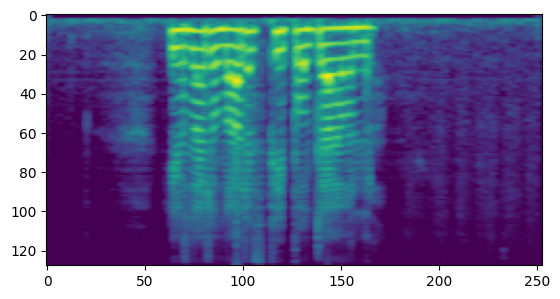

In [109]:
import matplotlib.pyplot as plt

plt.imshow(tmp[0][0])

In [110]:
tmp[0][0].shape

torch.Size([128, 253])

In [111]:
unscaled = (tmp[0][0] - 1) * 80
unscaled = np.array(unscaled)

In [112]:
# Load your mel spectrogram in dB
mel_spectrogram_db = unscaled  # replace with your actual mel spectrogram data

# Convert mel spectrogram from dB to magnitude
mel_spectrogram = librosa.db_to_amplitude(mel_spectrogram_db)


# Use librosa's inverse mel spectrogram function to obtain the time-domain signal
sound_wave = librosa.feature.inverse.mel_to_audio(
    mel_spectrogram, sr=16000, n_fft=2048, hop_length=1024 // 4
)

# Optionally, you can normalize the audio signal
sound_wave /= np.max(np.abs(sound_wave), axis=0)

In [113]:
import soundfile as sf

sf.write("recon.wav", sound_wave, 16000)